<center><h1>Retail Rocket eCommerce Recommender System</h1></center>
<center><h3>Mengqi Han</h3></center>

# Table of Contents

1. [Import Data](#1.-Import-Data)
2. [EDA of Dataset](#2.-EDA-of-Dataset)
3. [Create a New Dataset for Regression Modelling](#3.-Create-a-New-Dataset-for-Regression-Modelling)
    -  [3.1 EDA of modelling dataset](#3.1-EDA-of-modelling-dataset)
    -  [3.2 Baseline Model](#3.2-Baseline-Model)
    -  [3.3 Model Selection](#3.3-Model-Selection)
    -  [3.4 Grid Search and Hyperparameter tuning for Neural Network](#3.4-Grid-Search-and-Hyperparameter-tuning-for-Neural-Network)
    -  [3.5 Stacking](#3.5-Stacking)
    -  [3.6 Surrogate model](#3.6-Surrogate-model)
    -  [3.7 Permutation Importance](#3.7-Permutation-Importance)
4. [Recommendation System](#4.-Recommendation-System)

In [263]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.tree import DecisionTreeRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import scikeras
from scikeras.wrappers import KerasRegressor
from keras.callbacks import History

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1. Import Data

## 1.1 Event

In [3]:
event = pd.read_csv('C://Users//Hanme//Desktop//ML dataset//Retailrocket recommender system dataset//events.csv')
event.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [29]:
# converting Unix timestamp to readable format, time consuming steps
event.timestamp = event.timestamp.apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S')))

In [106]:
# imbalanced view and transaction
event.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

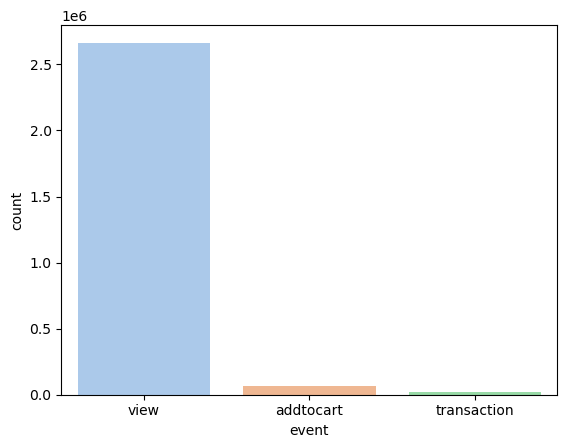

In [36]:
# 3 events: view, addtocart, transaction
event.event.value_counts()
sns.countplot(x= 'event', data=event, palette="pastel");

In [39]:
# number of customers purchased items
customer_purchased = event[event.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [40]:
event.to_csv('events.csv', index=False)

In [2]:
events = pd.read_csv('events.csv')
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-01 22:02:12,257597,view,355908,NaN
1,2015-06-01 22:50:14,992329,view,248676,NaN
2,2015-06-01 22:13:19,111016,view,318965,NaN
3,2015-06-01 22:12:35,483717,view,253185,NaN
4,2015-06-01 22:02:17,951259,view,367447,NaN


## 1.2 Item

In [9]:
item_1 = pd.read_csv('C://Users//Hanme//Desktop//ML dataset//Retailrocket recommender system dataset//item_properties_part1.csv')

In [10]:
item_2 = pd.read_csv('C://Users//Hanme//Desktop//ML dataset//Retailrocket recommender system dataset//item_properties_part2.csv')

In [27]:
# concat two tables into one
items = pd.concat([item_1, item_2], axis=0)
items.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [30]:
# converting Unix timestamp to readable format, time consuming steps
items.timestamp = items.timestamp.apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S')))

In [41]:
# save to csv
items.to_csv('items.csv', index=False)

In [3]:
# read items csv
items = pd.read_csv('items.csv')
items.head()

,timestamp,itemid,property,value
0,2015-06-27 20:00:00,460429,categoryid,1338
1,2015-09-05 20:00:00,206783,888,1116713 960601 n277.200
2,2015-08-08 20:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-09 20:00:00,59481,790,n15360.000
4,2015-05-16 20:00:00,156781,917,828513


- Item id will be the unique item identifier

- All values in the “item_properties.csv” file excluding "categoryid" and "available" properties were hashed due to confidential issues. 

- Property is the Item's attributes such as category id and availability while the rest are hashed for confidentiality purposes

- Value is the item's property value e.g. availability is 1 if there is stock and 0 otherwise

- Note: Values that start with "n" indicate that the value preceeding it is a number e.g. n277.200 is equal to 277.2

## 1.3 Category

In [4]:
category = pd.read_csv('C://Users//Hanme//Desktop//ML dataset//Retailrocket recommender system dataset//category_tree.csv')
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


# 2. EDA of Dataset

## 2.1 Product analysis

In [5]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  object
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(1), object(3)
memory usage: 618.8+ MB


In [6]:
# no null values in items
items.isnull().value_counts()

timestamp  itemid  property  value
False      False   False     False    20275902
dtype: int64

In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      object 
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 105.1+ MB


In [8]:
# 2733644 null value in transactionid
events.isnull().value_counts()

timestamp  visitorid  event  itemid  transactionid
False      False      False  False   True             2733644
                                     False              22457
dtype: int64

In [9]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [10]:
# 25 null value in parentid
category.isnull().value_counts()

categoryid  parentid
False       False       1644
            True          25
dtype: int64

In [11]:
# items under property 'category id'
items.loc[(items.property=='categoryid')].sort_values('timestamp').head()

,timestamp,itemid,property,value
16430715,2015-05-09 20:00:00,75757,categoryid,926
10149557,2015-05-09 20:00:00,103747,categoryid,1455
14099137,2015-05-09 20:00:00,51970,categoryid,686
10149444,2015-05-09 20:00:00,274307,categoryid,1553
5076200,2015-05-09 20:00:00,84814,categoryid,568


In [12]:
# items under property 'available'
items.loc[(items.property=='available')].sort_values('timestamp').head()

,timestamp,itemid,property,value
17134280,2015-05-09 20:00:00,150583,available,1
12199921,2015-05-09 20:00:00,353086,available,0
3201401,2015-05-09 20:00:00,73875,available,0
17471604,2015-05-09 20:00:00,394841,available,0
9154196,2015-05-09 20:00:00,60194,available,1


In [14]:
# items with categoryid and available as propery
items = items.loc[items.property.isin(['categoryid', 'available']), :]
print("items with categoryid and available as propery:", items.size)
items.head()

items with categoryid and available as propery: 9167412


,timestamp,itemid,property,value
0,2015-06-27 20:00:00,460429,categoryid,1338
5,2015-07-04 20:00:00,285026,available,0
15,2015-07-18 20:00:00,186518,available,0
79,2015-06-06 20:00:00,423682,available,0
82,2015-06-13 20:00:00,316253,available,1


In [15]:
# grouping itemid by its event type and creating list of each of them
grouped = events.groupby('event')['itemid'].apply(list)
grouped

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

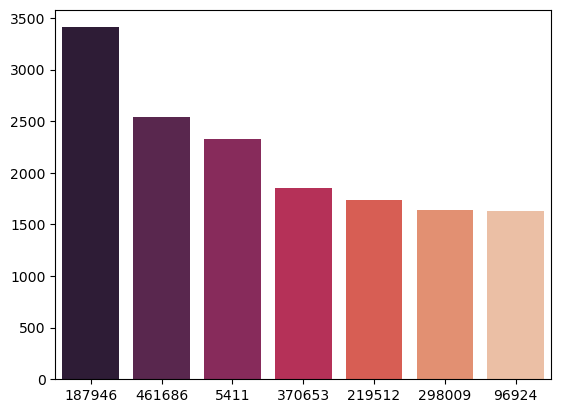

In [50]:
# check the most VIEWED items

import operator
views = grouped['view']
# creating dictionary for key value pair 
count_view ={}
# since views is a list, we will convert it into numpy array for further manipulations
views = np.array(views[:])
# counting uniques values of views of this numpy views array
unique, counts = np.unique(views, return_counts=True)
# converting unique and counts as a dictionay with key as unique and value as counts
count_view = dict(zip(unique, counts))
# sorting the dictionary
sort_count_view = sorted(count_view.items(), key = operator.itemgetter(1), reverse = True)
# keeping number of unique views on X-axis
x = [i[0] for i in sort_count_view[:7]]
# keeping count number of views on Y-axis
y = [i[1] for i in sort_count_view[:7]]
sns.barplot(x=x, y=y, order=x, palette="rocket");

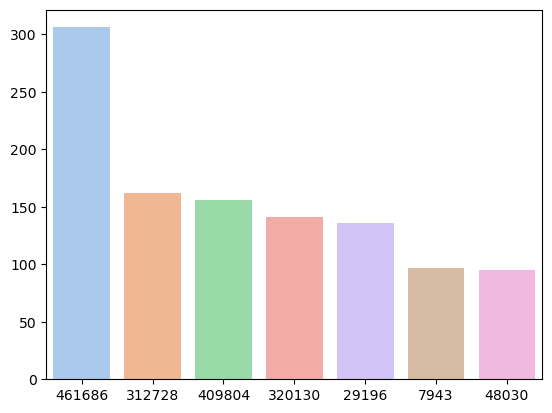

In [51]:
# check the most ADDTOCART items

addtocart = grouped['addtocart']
# creating dictionary for key value pair 
count_addtocart ={}
# since addtocart is a list, we will convert it into numpy array for further manipulations
addtocart = np.array(addtocart[:])
# counting uniques values of addtocart items of this numpy addtocart array
unique, counts = np.unique(addtocart, return_counts=True)
# converting unique and counts as a dictionay with key as unique and value as counts
count_addtocart = dict(zip(unique, counts))
# sorting the dictionary
sort_count_addtocart = sorted(count_addtocart.items(), key = operator.itemgetter(1), reverse = True)
# keeping number of unique views on X-axis
x = [i[0] for i in sort_count_addtocart[:7]]
# keeping count number of views on Y-axis
y = [i[1] for i in sort_count_addtocart[:7]]
sns.barplot(x=x, y=y, order=x, palette="pastel");

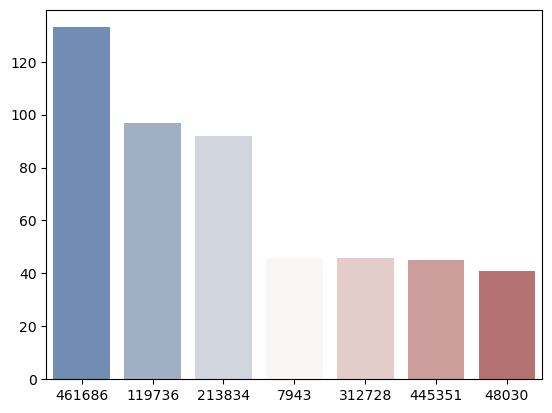

In [52]:
# check the most TRANSACTION items

transaction = grouped['transaction']
# creating dictionary for key value pair 
count_transaction ={}
# since addtocart is a list, we will convert it into numpy array for further manipulations
transaction = np.array(transaction[:])
# counting uniques values of addtocart items of this numpy addtocart array
unique, counts = np.unique(transaction, return_counts=True)
# converting unique and counts as a dictionay with key as unique and value as counts
count_transaction = dict(zip(unique, counts))
# sorting the dictionary
sort_count_transaction = sorted(count_transaction.items(), key = operator.itemgetter(1), reverse = True)
# keeping number of unique views on X-axis
x = [i[0] for i in sort_count_transaction[:7]]
# keeping count number of views on Y-axis
y = [i[1] for i in sort_count_transaction[:7]]
sns.barplot(x=x, y=y, order=x, palette="vlag");

In [53]:
#analyzing itemid = 461686
events.loc[(events.itemid==461686)]

,timestamp,visitorid,event,itemid,transactionid
5632,2015-06-01 10:23:59,1026179,view,461686,NaN
8782,2015-06-01 09:29:13,668227,view,461686,NaN
9651,2015-05-31 23:35:09,693466,view,461686,NaN
10749,2015-06-01 15:07:44,248754,view,461686,NaN
13618,2015-06-01 00:05:26,1207651,view,461686,NaN
...,...,...,...,...,...
2753402,2015-07-31 07:10:37,340886,view,461686,NaN
2754441,2015-07-31 15:36:56,537015,view,461686,NaN
2755192,2015-07-31 15:01:04,537015,view,461686,NaN
2755370,2015-07-31 14:47:47,388278,addtocart,461686,NaN


## 2.2 Customer analysis

In [16]:
# all unique visitors
all_customers = events['visitorid'].unique()
print("Unique visitors:", all_customers.size)

# all visitors
print('Total visitors:', events['visitorid'].size)

Unique visitors: 1407580
Total visitors: 2756101


In [17]:
# get all the customers who bought something
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [18]:
# get visitors who didn't buy anything
customer_browsed = [x for x in all_customers if x not in customer_purchased]
len(customer_browsed)

1395861

## 2.3 Concat a summary table

In [17]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-01 22:02:12,257597,view,355908,NaN
1,2015-06-01 22:50:14,992329,view,248676,NaN
2,2015-06-01 22:13:19,111016,view,318965,NaN
3,2015-06-01 22:12:35,483717,view,253185,NaN
4,2015-06-01 22:02:17,951259,view,367447,NaN


In [22]:
# check the unique items number in events df
events.itemid.nunique()

235061

In [18]:
items.head()

,timestamp,itemid,property,value
0,2015-06-27 20:00:00,460429,categoryid,1338
1,2015-09-05 20:00:00,206783,888,1116713 960601 n277.200
2,2015-08-08 20:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-09 20:00:00,59481,790,n15360.000
4,2015-05-16 20:00:00,156781,917,828513


In [41]:
# create items_ that filtered the unique itemid with categoryid value
items_ = items[items.property == 'categoryid'].drop(['timestamp', 'property'], axis=1).drop_duplicates()
items_.head()

,itemid,value
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


In [42]:
# convert object to int64 for value in items_, perpare for merge table
items_.value = items_.value.astype('int64')

In [19]:
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [36]:
# check the datatype of category
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [47]:
# create the merged data with categoryid and parentid for items in events dataframe
data = events.merge(items_, on='itemid').merge(category, left_on='value', right_on='categoryid').drop('value', axis=1)
data.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
0,2015-06-01 22:02:12,257597,view,355908,NaN,1173,805.0
1,2015-06-01 13:42:45,981382,view,355908,NaN,1173,805.0
2,2015-06-08 21:07:35,979686,view,355908,NaN,1173,805.0
3,2015-06-15 08:31:50,479732,view,355908,NaN,1173,805.0
4,2015-06-14 16:51:34,397425,view,355908,NaN,1173,805.0


In [49]:
data.to_csv('data.csv', index = False)

### 2.3.1 EDA of summarized data

In [19]:
data = pd.read_csv('data.csv')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709446 entries, 0 to 2709445
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      object 
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
 5   categoryid     int64  
 6   parentid       float64
dtypes: float64(2), int64(3), object(2)
memory usage: 144.7+ MB


In [21]:
# convert the datatype
data.timestamp = data.timestamp.astype('datetime64')

In [22]:
# check null values
data.isnull().value_counts()

timestamp  visitorid  event  itemid  transactionid  categoryid  parentid
False      False      False  False   True           False       False       2686059
                                     False          False       False         23369
                                     True           False       True             18
dtype: int64

In [23]:
data = data.drop_duplicates()

In [24]:
# 2 millions rows
len(data)

2705278

In [25]:
data.transactionid.isnull().value_counts()

True     2681915
False      23363
Name: transactionid, dtype: int64

In [26]:
data.event.value_counts()

view           2610352
addtocart        71563
transaction      23363
Name: event, dtype: int64

In [27]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
0,2015-06-01 22:02:12,257597,view,355908,NaN,1173,805.0
1,2015-06-01 13:42:45,981382,view,355908,NaN,1173,805.0
2,2015-06-08 21:07:35,979686,view,355908,NaN,1173,805.0
3,2015-06-15 08:31:50,479732,view,355908,NaN,1173,805.0
4,2015-06-14 16:51:34,397425,view,355908,NaN,1173,805.0


### 2.3.2 Timestamp

In [28]:
data.sort_values(by=['visitorid','itemid', 'timestamp'])

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
1377436,2015-09-11 13:55:17,0,view,67045,NaN,333,1497.0
1100660,2015-09-11 13:49:49,0,view,285930,NaN,1188,1497.0
1574720,2015-09-11 13:52:39,0,view,357564,NaN,256,1257.0
557411,2015-08-13 10:46:06,1,view,72028,NaN,1192,955.0
1995309,2015-08-07 11:01:08,2,view,216305,NaN,299,73.0
...,...,...,...,...,...,...,...
651564,2015-06-10 14:46:08,1407575,view,121220,NaN,1221,1426.0
1530554,2015-06-03 08:01:29,1407576,view,356208,NaN,175,1492.0
1979486,2015-05-17 14:48:04,1407577,view,427784,NaN,1237,623.0
900282,2015-05-16 18:21:23,1407578,view,188736,NaN,1584,1562.0


In [29]:
# obtain vistor id,item id, and date time of 'tranaction'
item_tra=data[['visitorid','itemid','timestamp']][data['event']=='transaction']
# obtain vistor id,item id, and date time of 'add to cart'
item_atc=data[['visitorid','itemid','timestamp']][data['event']=='addtocart']
# obtain vistor id,item id, and date time of 'view'
item_viw=data[['visitorid','itemid','timestamp']][data['event']=='view']

In [151]:
# create a dataframe of visitor, itemid found in all three events
time_df=item_tra.merge(item_atc, how='inner', on=['visitorid','itemid'], suffixes=[' (transaction)', ' (add_to_cart)'])
time_df=time_df.merge(item_viw, how='inner', on=['visitorid','itemid'])
time_df=time_df.rename(columns={'timestamp':'timestamp (view)'})
time_df.head()

,visitorid,itemid,timestamp (transaction),timestamp (add_to_cart),timestamp (view)
0,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-06-10 11:23:08
1,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-05-06 10:00:52
2,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-05-12 10:29:00
3,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-05-28 10:50:57
4,76757,280375,2015-06-10 11:25:41,2015-05-28 10:51:55,2015-06-10 11:23:08


In [40]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116294 entries, 0 to 116293
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   visitorid                116294 non-null  int64         
 1   itemid                   116294 non-null  int64         
 2   timestamp (transaction)  116294 non-null  datetime64[ns]
 3   timestamp (add_to_cart)  116294 non-null  datetime64[ns]
 4   timestamp (view)         116294 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2)
memory usage: 5.3 MB


In [152]:
# calculate the time differences
time_df['cart_to_transaction'] = (time_df['timestamp (transaction)'] - time_df['timestamp (add_to_cart)']).apply(lambda x: x.total_seconds()/3600)
time_df['first_view'] = time_df.groupby('itemid')['timestamp (view)'].transform('min')
time_df['firstview_to_cart'] = (time_df['timestamp (add_to_cart)'] - time_df['first_view']).apply(lambda x: x.total_seconds()/3600)

time_df.head()

,visitorid,itemid,timestamp (transaction),timestamp (add_to_cart),timestamp (view),cart_to_transaction,first_view,firstview_to_cart
0,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-06-10 11:23:08,0.037222,2015-05-06 10:00:52,841.376389
1,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-05-06 10:00:52,0.037222,2015-05-06 10:00:52,841.376389
2,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-05-12 10:29:00,0.037222,2015-05-06 10:00:52,841.376389
3,76757,280375,2015-06-10 11:25:41,2015-06-10 11:23:27,2015-05-28 10:50:57,0.037222,2015-05-06 10:00:52,841.376389
4,76757,280375,2015-06-10 11:25:41,2015-05-28 10:51:55,2015-06-10 11:23:08,312.562778,2015-05-06 10:00:52,528.850833


In [53]:
min(time_df['cart_to_transaction'])

-2715.375

In [54]:
max(time_df['cart_to_transaction'])

2715.571111111111

In [61]:
min(time_df['firstview_to_cart'])

-2381.6722222222224

In [62]:
max(time_df['firstview_to_cart'])

3276.660277777778

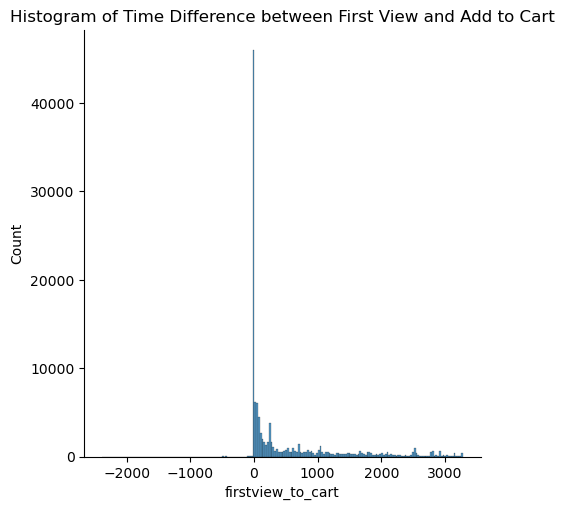

In [57]:
# Note: some item were purchased in multiple times, before the earliest date in this dataset, the view data was not collected, so that negetive value exists.
sns.displot(time_df['firstview_to_cart'])
plt.title('Histogram of Time Difference between First View and Add to Cart');

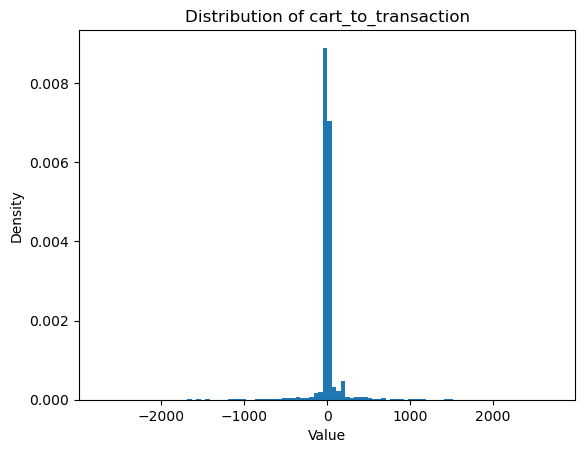

In [65]:
# Plot a histogram of the data
plt.hist(time_df['cart_to_transaction'], bins=100, density=True)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of cart_to_transaction');

### 2.3.3 Category

In [16]:
data['transactionid'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: transactionid, dtype: float64

In [20]:
data['purchased'] = data['transactionid'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2705278 entries, 0 to 2709445
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   categoryid     int64         
 6   parentid       float64       
 7   purchased      int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 185.8+ MB


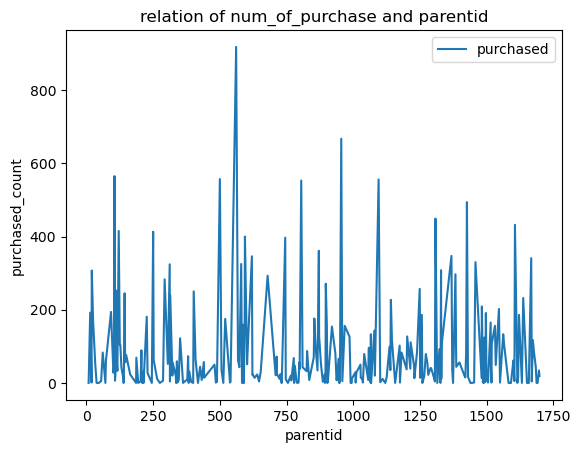

In [22]:
# distribution of category
cate_plot = pd.DataFrame(data.groupby('parentid')['purchased'].sum())

cate_plot.plot()
plt.ylabel('purchased_count')
plt.title('relation of num_of_purchase and parentid');

### Original dataset analysis

- 1. current dataset has no column that canbe used for modelling
    - timestamp: 
        - able to create day, hour, year, month, which is useless in predicting purchase or not.
        - time difference in view, addtocart, transaction, but the issue is, by creating timediff, other columns data losed.
    - visitorid, itemid, cateforyid, parentid: in large number of unique categorical value, very low relationship with label purchased.
    - transactionid need to be dropped as it is parent column of label purchased.

- 2. new columns created: 
    - item_visitor_views_num: views_num of each item by each visitor
    - add_to_cart: binery value -- 0 for false 1 for true
    
- 3. try to build the modelling dataset using the original dataset, however, the data actually contains duplicates which cannot be removed by drop.duplicates() because:
    - due to the created new columns, the item_visitor_views_num will be unique for different views, even the visitorid and itemid is same. 
    - for event in addtocart or transaction, which the visitorid and itemid must already exist in the dataset, however, as it has multipule view times, it's not unique rows and cannot be searched, matached, and insert into the existed rows. 
    - Therefore, this dataset is not able to build a supervised model. 

In [24]:
ds = data.copy()
ds.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid,purchased
0,2015-06-01 22:02:12,257597,view,355908,NaN,1173,805.0,0
1,2015-06-01 13:42:45,981382,view,355908,NaN,1173,805.0,0
2,2015-06-08 21:07:35,979686,view,355908,NaN,1173,805.0,0
3,2015-06-15 08:31:50,479732,view,355908,NaN,1173,805.0,0
4,2015-06-14 16:51:34,397425,view,355908,NaN,1173,805.0,0


In [25]:
ds = ds.drop(['timestamp', 'transactionid'], axis = 1)

In [26]:
# views_num of each item by each visitor
ds['item_visitor_views_num'] = ds[ds['event']=='view'].groupby(['visitorid', 'itemid'])['event'].transform('count')

In [36]:
# min of this column is 1, missing value will be event in addtocart or transaction
ds['item_visitor_views_num'].min()

1.0

In [43]:
ds['item_visitor_views_num'].max()

352.0

In [27]:
# whether the item added to cart
ds['add_to_cart'] = ds['event'].apply(lambda x: 1 if x == 'addtocart' else 0)

In [28]:
ds.head()

,visitorid,event,itemid,categoryid,parentid,purchased,item_visitor_views_num,add_to_cart
0,257597,view,355908,1173,805.0,0,1.0,0
1,981382,view,355908,1173,805.0,0,1.0,0
2,979686,view,355908,1173,805.0,0,1.0,0
3,479732,view,355908,1173,805.0,0,1.0,0
4,397425,view,355908,1173,805.0,0,1.0,0


In [29]:
# remove data that visitor purchased same item multipule times
ds = ds.drop_duplicates()

In [33]:
# convert categorical datatype to category
ds['visitorid'] = ds['visitorid'].astype('category')
ds['itemid'] = ds['itemid'].astype('category')
ds['categoryid'] = ds['categoryid'].astype('category')
ds['parentid'] = ds['parentid'].astype('category')
ds['event'] = ds['event'].astype('category')
ds['add_to_cart'] = ds['add_to_cart'].astype('category')
ds['purchased'] = ds['purchased'].astype('category')

In [38]:
# drop visitorid and duplicates
ds = ds.drop('visitorid', axis=1).drop_duplicates()

In [39]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361663 entries, 0 to 2709445
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   event                   361663 non-null  category
 1   itemid                  361663 non-null  category
 2   categoryid              361663 non-null  category
 3   parentid                361660 non-null  category
 4   purchased               361663 non-null  category
 5   item_visitor_views_num  324154 non-null  float64 
 6   add_to_cart             361663 non-null  category
dtypes: category(6), float64(1)
memory usage: 14.8 MB


In [41]:
ds.itemid.nunique()

185246

In [45]:
ds[ds['item_visitor_views_num'].isnull()]

,event,itemid,categoryid,parentid,purchased,item_visitor_views_num,add_to_cart
66,addtocart,280375,1173,805.0,0,NaN,1
135,transaction,280375,1173,805.0,1,NaN,0
545,addtocart,16813,1173,805.0,0,NaN,1
692,transaction,16813,1173,805.0,1,NaN,0
949,addtocart,391289,1173,805.0,0,NaN,1
...,...,...,...,...,...,...,...
2709233,addtocart,90992,563,121.0,0,NaN,1
2709237,transaction,90992,563,121.0,1,NaN,0
2709332,addtocart,336069,662,1028.0,0,NaN,1
2709336,transaction,336069,662,1028.0,1,NaN,0


In [40]:
from ydata_profiling import ProfileReport

profile = ProfileReport(ds)

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

# 3. Create a New Dataset for Regression Modelling

### Goal: predict purchase or not, purchase ability
- from data df, create a new df for modelling which contains:
    - visitorid, num_items_viewed, view_count, bought_count, purchased
    - This table will contain distinct visitorid, so that it's not able to create a column for addtocart and categoryid

In [30]:
len(all_customers)

1407580

In [31]:
len(customer_purchased)

11719

In [32]:
len(customer_browsed)

1395861

In [154]:
def create_dataframe(visitor_list):
    df_array = []
    for index in visitor_list:
        # create the base dataframe of each visitor that prepare for following data extraction 
        v_df = data[data.visitorid == index]
        m_df = time_df[time_df.visitorid == index]
        
        temp = []
        # add visitor id
        temp.append(index)
        
        # num_items_viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)
        
        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add timediff of firstview_to_cart
        temp.append(m_df['firstview_to_cart'].mean())
        
        #Add timediff of cart_to_transaction
        temp.append(m_df['cart_to_transaction'].mean())
        
        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)
        
        #Then create binery 0 or 1 for purchased
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        df_array.append(temp)
        
    return pd.DataFrame(df_array, columns=['visitorid', 'num_items_viewed', 'view_count', 'firstview_to_cart', 'cart_to_transaction', 'bought_count', 'purchased'])

In [156]:
buying_visitors_df = create_dataframe(customer_purchased)
buying_visitors_df.head()

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased
0,599528,2,15,0.012500,0.093056,1,1
1,121688,13,16,-0.145082,0.927173,12,1
2,552148,1,1,0.036667,0.009722,1,1
3,102019,2,6,0.024167,0.259722,2,1
4,189384,7,25,479.378596,0.051974,2,1


In [157]:
# This table contains data for all the customer that make a payment, need to concat view data 
buying_visitors_df.shape

(11719, 7)

In [161]:
#Let's shuffle the viewing visitors list for randomness
import random
random.shuffle(customer_browsed)

In [162]:
# get 23438 samples from the viewing visitors list so that there is a 0.33 split for training and test data.
# if select all customer, imbalanced data can be addressed by randomoversampler etc. but the dataset will be huge and require longer running time.
viewing_visitors_df = create_dataframe(customer_browsed[0:23438])

In [163]:
data_ml = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

In [164]:
# shuffle main_df first
data_ml = data_ml.sample(frac=1)

In [165]:
data_ml.to_csv('data_ml.csv', index=False)

## 3.1 EDA of modelling dataset

In [273]:
data_ml = pd.read_csv('data_ml.csv')
data_ml.head()

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased
0,299645,1,1,NaN,NaN,0,0
1,901655,1,2,NaN,NaN,0,0
2,964726,4,12,118.104722,0.0425,1,1
3,368247,1,1,NaN,NaN,0,0
4,484387,1,1,NaN,NaN,0,0


In [274]:
# view_rate is the total number of items viewed in total view number, lower view_rate refer to that the customer focus on a specific item.
data_ml['view_rate'] = data_ml['num_items_viewed']/data_ml['view_count']

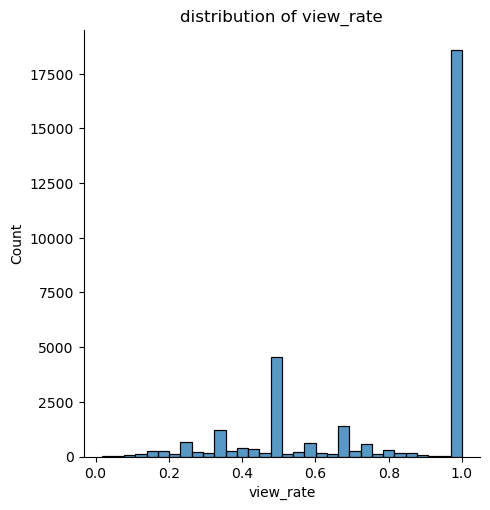

In [275]:
# distribution of view_rate
sns.displot(data_ml['view_rate'])
plt.title('distribution of view_rate');

In [276]:
# purchase_rate refer to the purchase ability, the total purchase items number / total view number. The higher purchase_rate, the higher purchase ability.
data_ml['purchase_rate'] = data_ml['bought_count']/data_ml['view_count']

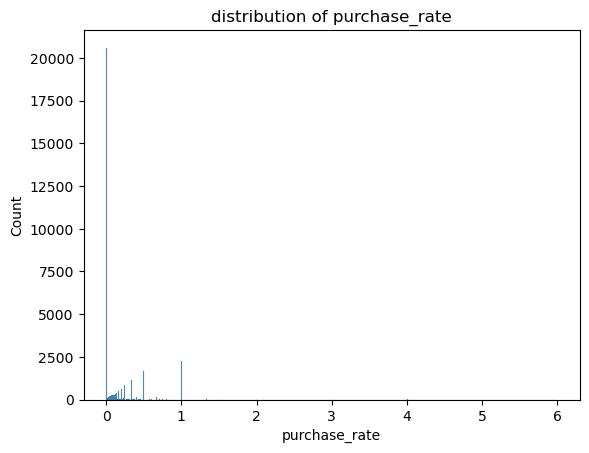

In [279]:
# distribution of purchase_rate
sns.histplot(data_ml['purchase_rate'])
plt.title('distribution of purchase_rate');

In [169]:
data_ml.purchased.value_counts()

0    23588
1    11569
Name: purchased, dtype: int64

In [173]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35157 entries, 0 to 35156
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitorid            35157 non-null  int64  
 1   num_items_viewed     35157 non-null  int64  
 2   view_count           35157 non-null  int64  
 3   firstview_to_cart    9791 non-null   float64
 4   cart_to_transaction  9791 non-null   float64
 5   bought_count         35157 non-null  int64  
 6   purchased            35157 non-null  int64  
 7   view_rate            31705 non-null  float64
 8   purchase_rate        32134 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 2.4 MB


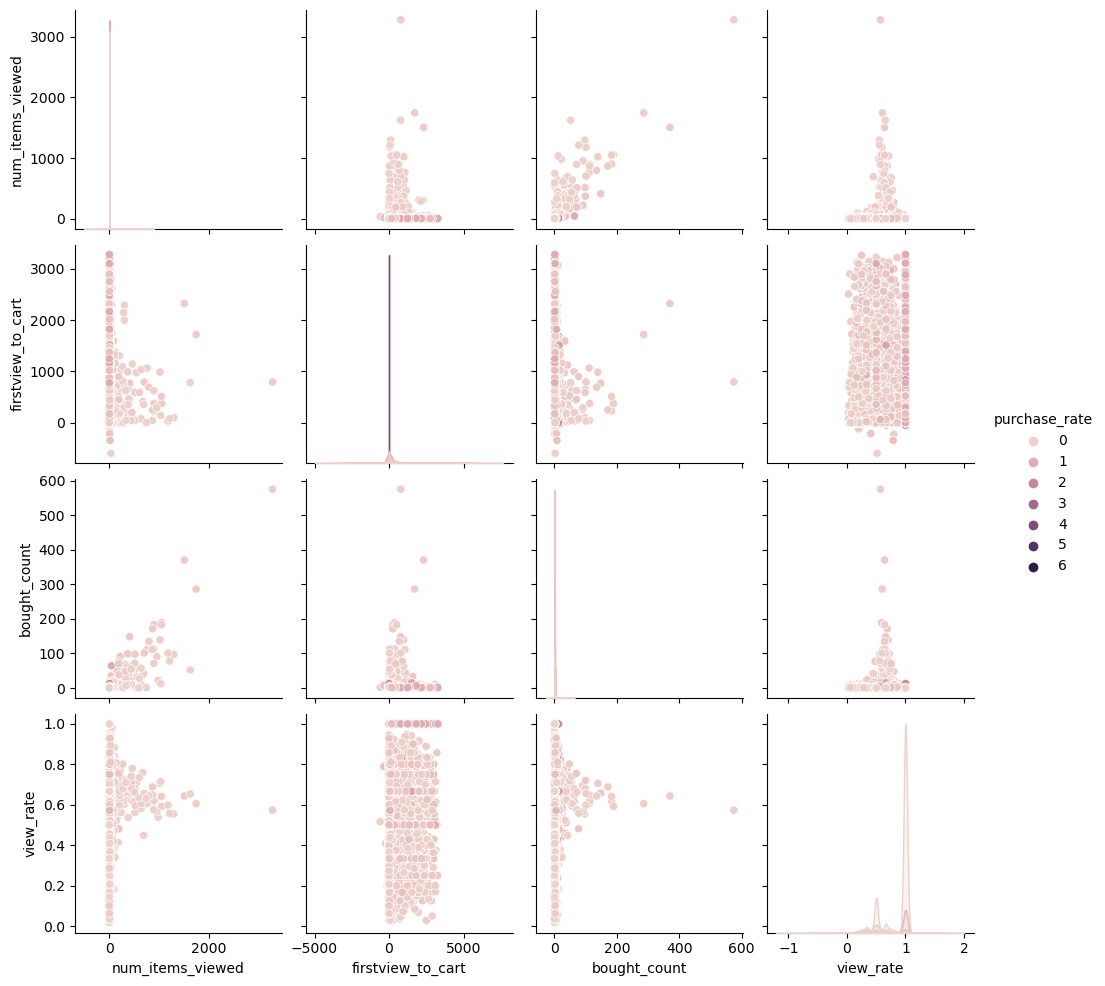

In [258]:
sns.pairplot(data_ml, x_vars = ['num_items_viewed', 'firstview_to_cart', 'bought_count', 'view_rate'],
             y_vars = ['num_items_viewed', 'firstview_to_cart', 'bought_count', 'view_rate'],  hue = 'purchase_rate');

In [281]:
data_ml.drop('visitorid', axis=1).corr().style.background_gradient(cmap='coolwarm',axis = None)

,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
num_items_viewed,1.000000,0.990989,0.009150,-0.003294,0.856639,0.096755,-0.048262,-0.017260
view_count,0.990989,1.000000,0.008775,0.006017,0.852401,0.108997,-0.082439,-0.018717
firstview_to_cart,0.009150,0.008775,1.000000,0.003346,0.016086,nan,0.012842,0.018534
cart_to_transaction,-0.003294,0.006017,0.003346,1.000000,-0.008059,nan,-0.057414,-0.047450
bought_count,0.856639,0.852401,0.016086,-0.008059,1.000000,0.178362,-0.085311,0.087358
purchased,0.096755,0.108997,nan,nan,0.178362,1.000000,-0.463925,0.660328
view_rate,-0.048262,-0.082439,0.012842,-0.057414,-0.085311,-0.463925,1.000000,-0.043895
purchase_rate,-0.017260,-0.018717,0.018534,-0.047450,0.087358,0.660328,-0.043895,1.000000


In [280]:
from ydata_profiling import ProfileReport

profile = ProfileReport(data_ml)

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Hanme\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Hanme\anaconda3\lib\site-packages\ydata_profiling\model\correlations.py:67: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'cannot specify integer `bins` when input data contains infinity')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Major issues:
- purchase_rate has inifite values, because view_count has zero value, which need to be dropped.
- skewed data: num_items_viewed, view_count, bought_count
- missing value: first_view_to_cart, view_rate, cart_to_transaction, purchase_rate
- zeros: 
    - num_items_viewed: 9.5% zeros
    - view_count: 9.5% zeros
    - bought_count: 67.1% zeros
    
label: can be purchased, purchase_rate. prefer to use purchase_rate, which can reflect the customer's purchase ability.

If label is purchase_rate:
- columns need to be dropped: view_count, purchased

If label is purchased:
- columns need to be dropped: view_count, cart_to_transaction, purchase_rate, firstview_to_cart(None relation to label), cart_to_transaction (None relation to label). In this case, it only leaves num_items_viewed and bought_count. Poor model performance is foreseeable.

Therefore, the label should be purchase_rate.

In [182]:
data_ml.columns

Index(['visitorid', 'num_items_viewed', 'view_count', 'firstview_to_cart',
       'cart_to_transaction', 'bought_count', 'purchased', 'view_rate',
       'purchase_rate'],
      dtype='object')

### 3.1.1 purchase_rate, to be the label, need to drop rows in infinite value

In [189]:
# Drop rows with infinite values in the "purchase_rate" column
data_ml = data_ml[~np.isinf(data_ml['purchase_rate'])]

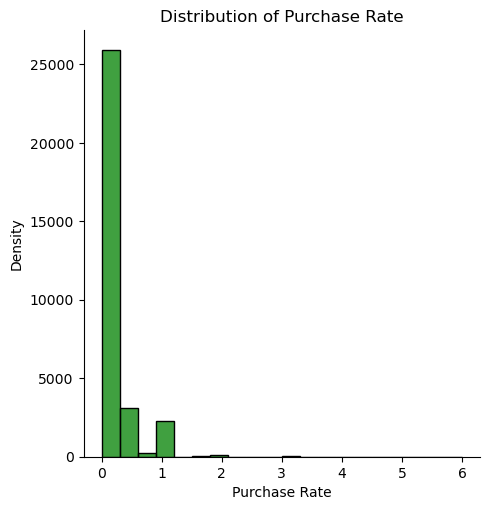

In [263]:
sns.displot(data_ml['purchase_rate'], bins=20, color='green')
plt.title('Distribution of Purchase Rate')
plt.xlabel('Purchase Rate')
plt.ylabel('Density');

In [265]:
# check whether these rows be dropped
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34728 entries, 0 to 35156
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitorid            34728 non-null  int64  
 1   num_items_viewed     34728 non-null  int64  
 2   view_count           34728 non-null  int64  
 3   firstview_to_cart    9791 non-null   float64
 4   cart_to_transaction  9791 non-null   float64
 5   bought_count         34728 non-null  int64  
 6   purchased            34728 non-null  int64  
 7   view_rate            31705 non-null  float64
 8   purchase_rate        31705 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 3.7 MB


### 3.1.2 num_items_viewed

In [73]:
# cannot displot or histplot due to the skewed data
# by check the data distribution, seperate data into groups (0), (1), (2, 10), (11, 100), >100
data_ml['num_items_viewed'].value_counts()

1      20725
2       4552
0       3349
3       1998
4       1051
       ...  
796        1
608        1
188        1
484        1
135        1
Name: num_items_viewed, Length: 199, dtype: int64

In [75]:
data_ml['num_items_viewed'].value_counts().head(10)

1    20725
2     4552
0     3349
3     1998
4     1051
5      732
6      496
7      359
8      261
9      241
Name: num_items_viewed, dtype: int64

In [76]:
data_ml['num_items_viewed'].value_counts().tail(100)

270    1
134    1
954    1
260    1
289    1
      ..
796    1
608    1
188    1
484    1
135    1
Name: num_items_viewed, Length: 100, dtype: int64

C:\Users\Hanme\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


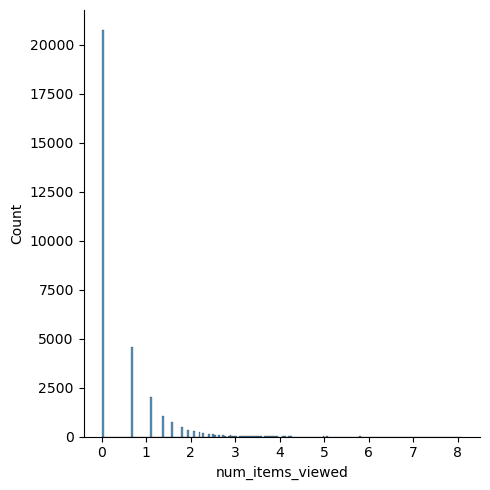

In [125]:
sns.displot(np.log(data_ml['num_items_viewed']));

### 3.1.3 view_count: to be dropped

In [118]:
# as this column is highly correlated with num_items_viewed and bought_count, this column is going to be dropped
# similar to above, view_count canbe devided into groups:(0, 1), (2, 10), (11, 100) >100

data_ml['view_count'].value_counts().tail(100)

213     1
358     1
160     1
579     1
1052    1
       ..
180     1
198     1
686     1
171     1
118     1
Name: view_count, Length: 100, dtype: int64

In [130]:
data_ml['view_count'].value_counts()

1      15326
2       5696
0       3349
3       2508
4       1747
       ...  
180        1
198        1
686        1
171        1
118        1
Name: view_count, Length: 255, dtype: int64

### 3.1.4 bought_count

C:\Users\Hanme\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


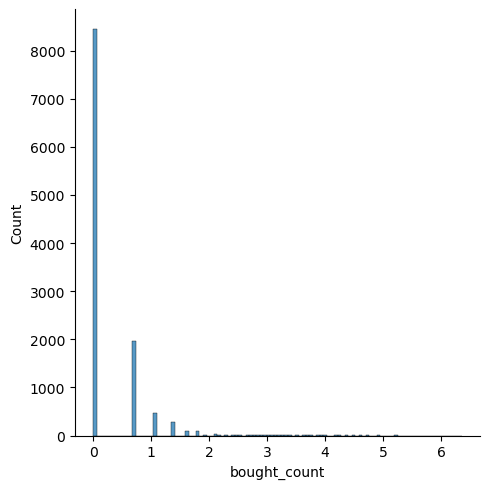

In [123]:
# use np.log to transform data to address skew issue. 
sns.displot(np.log(data_ml['bought_count']));

### 3.1.5 firstview_to_cart

In [186]:
# after checking the data's relation with label, consider to impute -1000 for null values.
# missing value need to be addressed
data_ml['firstview_to_cart'].isnull().value_counts()

True     25366
False     9791
Name: firstview_to_cart, dtype: int64

In [200]:
# 183 rows of negetive value in this column
# negetive value is due to item add_to_cart before the data collected.
data_ml[data_ml['firstview_to_cart'] < 0]

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
6,569471,2,2,-0.093889,0.137222,1,1,1.000000,0.500000
100,555265,6,13,-0.249444,0.608056,2,1,0.461538,0.153846
479,852875,2,3,-1.267778,0.149444,1,1,0.666667,0.333333
926,1103914,59,112,-0.126649,0.865676,8,1,0.526786,0.071429
1076,1167802,5,16,-0.312778,0.387500,4,1,0.312500,0.250000
...,...,...,...,...,...,...,...,...,...
33382,1053258,2,3,-0.005278,5.660000,1,1,0.666667,0.333333
33389,109721,2,2,-2.184722,0.066667,1,1,1.000000,0.500000
33725,220099,1,1,-0.025278,0.153056,1,1,1.000000,1.000000
34866,126834,6,7,-0.001157,0.207037,3,1,0.857143,0.428571


In [245]:
# the max is ~4 months
data_ml.sort_values('firstview_to_cart', ascending=False).head(100)

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
34650,921915,1,1,3276.660278,0.045278,1,1,1.00,1.000000
15460,1199182,1,1,3276.570278,0.058889,1,1,1.00,1.000000
18886,7633,1,4,3260.562222,0.142500,1,1,0.25,0.250000
4505,346832,1,1,3236.385278,0.100833,1,1,1.00,1.000000
13710,237886,2,2,3232.516944,0.068056,1,1,1.00,0.500000
...,...,...,...,...,...,...,...,...,...
21312,1294899,3,3,2786.395556,0.030833,1,1,1.00,0.333333
31985,276809,1,2,2786.351111,0.091389,2,1,0.50,1.000000
12364,618031,1,1,2781.591667,0.108056,1,1,1.00,1.000000
17145,939792,4,5,2781.492130,0.179167,2,1,0.80,0.400000


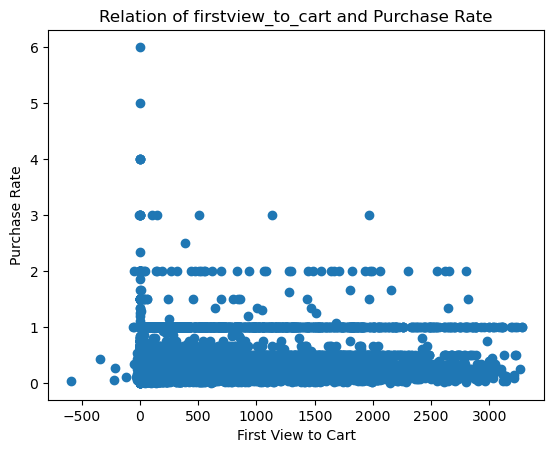

In [248]:
# plot the relation of firstview_to_cart with label purchase_rate
plt.scatter(data_ml['firstview_to_cart'], data_ml['purchase_rate'])
plt.xlabel('First View to Cart')
plt.ylabel('Purchase Rate')
plt.title('Relation of firstview_to_cart and Purchase Rate');

In [198]:
# the firstview_to_cart = 0.0 just becuase it shows in unit of hour, which is nearly zero.  
data_ml[data_ml['firstview_to_cart'] == 0]

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
7327,34667,3,4,0.0,0.052222,1,1,0.750000,0.250000
9115,1179416,1,1,0.0,0.085278,2,1,1.000000,2.000000
19637,1084182,1,1,0.0,0.026667,1,1,1.000000,1.000000
19698,533142,34,36,0.0,0.021944,1,1,0.944444,0.027778
20271,1013847,1,1,0.0,0.042778,1,1,1.000000,1.000000
20857,74832,1,2,0.0,0.056111,1,1,0.500000,0.500000
27187,1230189,1,2,0.0,0.026667,2,1,0.500000,1.000000
28115,20815,1,2,0.0,0.022500,1,1,0.500000,0.500000
31094,767636,1,2,0.0,0.035833,1,1,0.500000,0.500000
34741,1026145,1,1,0.0,0.037778,1,1,1.000000,1.000000


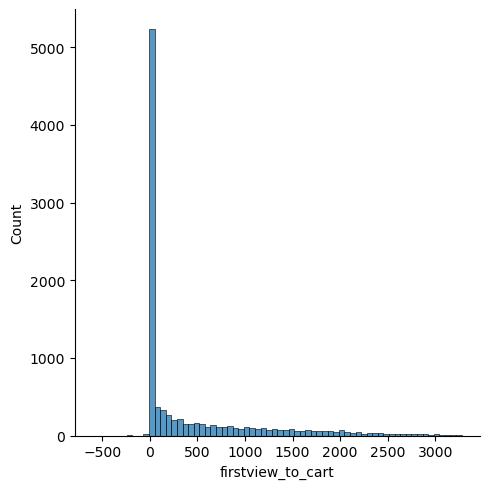

In [185]:
sns.displot(data_ml['firstview_to_cart']);

### 3.1.6 cart_to_transaction

In [272]:
# null value need to be addressed, consider to impute 2000.
data_ml['cart_to_transaction'].isnull().value_counts()

True     21914
False     9791
Name: cart_to_transaction, dtype: int64

In [273]:
# check the negetive values, which means multipule purchase made and the first record in the dataset is transaction in last purchase.
data_ml[data_ml['cart_to_transaction'] < 0]

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
167,432404,9,19,1209.224643,-5.448413,2,1,0.473684,0.105263
209,854134,1,3,558.229375,-9.943079,3,1,0.333333,1.000000
273,331366,45,63,238.566372,-1.014627,4,1,0.714286,0.063492
422,285368,7,184,197.340605,-7.746783,2,1,0.038043,0.010870
615,454102,10,26,522.199167,-0.005516,2,1,0.384615,0.076923
...,...,...,...,...,...,...,...,...,...
33726,814663,10,33,0.471961,-0.122949,4,1,0.303030,0.121212
34064,283553,31,91,1995.941028,-58.535139,2,1,0.340659,0.021978
34151,793038,2,5,0.182020,-0.000732,3,1,0.400000,0.600000
34697,1003058,8,12,1512.428519,-198.781914,15,1,0.666667,1.250000


In [275]:
# check its min value
data_ml['cart_to_transaction'].min()

-1478.0217322097376

In [274]:
# check the max
data_ml['cart_to_transaction'].max()

1198.9725

In [283]:
# the higher value, the longer timediff of cart to transaction made. For null values, it can be assume that cart_to_transaction is infinite. 
data_ml.sort_values('cart_to_transaction', ascending=False).head(100)['purchase_rate'].mean()

0.14905489183730244

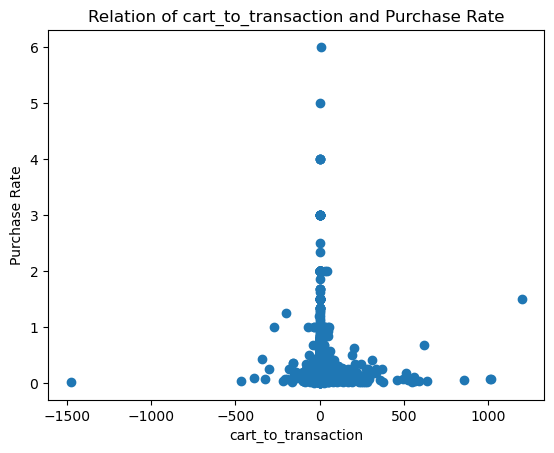

In [286]:
plt.scatter(data_ml['cart_to_transaction'], data_ml['purchase_rate'])
plt.xlabel('cart_to_transaction')
plt.ylabel('Purchase Rate')
plt.title('Relation of cart_to_transaction and Purchase Rate');

In [289]:
data_ml[(data_ml['cart_to_transaction']> -1) & (data_ml['cart_to_transaction']< 1)]

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
2,964726,4,12,118.104722,0.042500,1,1,0.333333,0.083333
6,569471,2,2,-0.093889,0.137222,1,1,1.000000,0.500000
7,608844,5,8,569.576914,0.150772,5,1,0.625000,0.625000
10,816384,8,11,730.030278,0.700278,1,1,0.727273,0.090909
12,199297,4,8,0.275556,0.017500,1,1,0.500000,0.125000
...,...,...,...,...,...,...,...,...,...
35129,1390774,3,4,114.318333,0.119167,2,1,0.750000,0.500000
35130,662735,1,1,1245.411389,0.069444,1,1,1.000000,1.000000
35145,989759,1,1,94.664444,0.007778,1,1,1.000000,1.000000
35146,1327109,4,7,59.349406,0.293299,5,1,0.571429,0.714286


### 3.1.7 view_rate
 - missing value dropped

In [254]:
# view_rate is the total number of items viewed in total view number, lower view_rate refer to that the customer focus on a specific item.
# missing value exists, need to be addressed. 
data_ml['view_rate'].isnull().value_counts()

False    31705
True      3023
Name: view_rate, dtype: int64

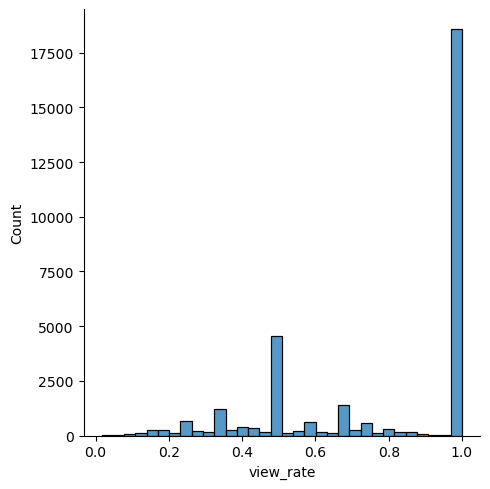

In [253]:
# no negetive value in view_rate, max value is 1. 
sns.displot(data_ml['view_rate']);

In [256]:
# In this case, num_items_viewed must be low
data_ml[(data_ml['view_rate'] == 1) & data_ml['purchase_rate'] != 0]

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
6,569471,2,2,-0.093889,0.137222,1,1,1.0,0.50
16,242567,1,1,910.991667,0.082500,1,1,1.0,1.00
22,1329391,8,8,0.191574,8.845185,6,1,1.0,0.75
52,1178082,1,1,0.007222,0.046944,1,1,1.0,1.00
72,1312927,1,1,1806.315000,0.780000,1,1,1.0,1.00
...,...,...,...,...,...,...,...,...,...
35069,119044,1,1,1.976389,0.032500,1,1,1.0,1.00
35121,341714,1,1,0.001944,0.036667,1,1,1.0,1.00
35130,662735,1,1,1245.411389,0.069444,1,1,1.0,1.00
35145,989759,1,1,94.664444,0.007778,1,1,1.0,1.00


In [266]:
data_ml[data_ml['view_rate'].isnull()]

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
5,1305994,0,0,NaN,NaN,0,0,NaN,NaN
9,297236,0,0,NaN,NaN,0,0,NaN,NaN
17,301379,0,0,NaN,NaN,0,0,NaN,NaN
24,906941,0,0,NaN,NaN,0,0,NaN,NaN
40,170488,0,0,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
35084,400106,0,0,NaN,NaN,0,0,NaN,NaN
35101,801025,0,0,NaN,NaN,0,0,NaN,NaN
35106,902843,0,0,NaN,NaN,0,0,NaN,NaN
35148,509549,0,0,NaN,NaN,0,0,NaN,NaN


In [267]:
# drop null value in view_rate
data_ml = data_ml.dropna(subset=['view_rate'])

In [269]:
# double check whether null value exist in purchase_rate
data_ml['purchase_rate'].isnull().value_counts()

False    31705
Name: purchase_rate, dtype: int64

In [270]:
data_ml.to_csv('df.csv', index=False)

## 3.2 Baseline Model 

- LinearRegression

In [33]:
df = pd.read_csv('df.csv')
df.head()

,visitorid,num_items_viewed,view_count,firstview_to_cart,cart_to_transaction,bought_count,purchased,view_rate,purchase_rate
0,299645,1,1,NaN,NaN,0,0,1.000000,0.000000
1,901655,1,2,NaN,NaN,0,0,0.500000,0.000000
2,964726,4,12,118.104722,0.0425,1,1,0.333333,0.083333
3,368247,1,1,NaN,NaN,0,0,1.000000,0.000000
4,484387,1,1,NaN,NaN,0,0,1.000000,0.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31705 entries, 0 to 31704
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitorid            31705 non-null  int64  
 1   num_items_viewed     31705 non-null  int64  
 2   view_count           31705 non-null  int64  
 3   firstview_to_cart    9791 non-null   float64
 4   cart_to_transaction  9791 non-null   float64
 5   bought_count         31705 non-null  int64  
 6   purchased            31705 non-null  int64  
 7   view_rate            31705 non-null  float64
 8   purchase_rate        31705 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 2.2 MB


### need to be address:
 - drop visitorid, view_count, purchased
 - missing value in firstview_to_cart, cart_to_transaction, consider to impute constant value, which higher than the largest one.
 - num_items_viewed, bought_count: consider to do np.log transform for skew data

In [35]:
df = df.drop(['visitorid', 'view_count', 'purchased'], axis=1)

In [36]:
df = df.drop_duplicates()

In [37]:
len(df)

10283

In [38]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df)

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Hanme\anaconda3\lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [39]:
df.head()

,num_items_viewed,firstview_to_cart,cart_to_transaction,bought_count,view_rate,purchase_rate
0,1,NaN,NaN,0,1.000000,0.000000
1,1,NaN,NaN,0,0.500000,0.000000
2,4,118.104722,0.042500,1,0.333333,0.083333
5,2,-0.093889,0.137222,1,1.000000,0.500000
6,5,569.576914,0.150772,5,0.625000,0.625000


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10283 entries, 0 to 31702
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   num_items_viewed     10283 non-null  int64  
 1   firstview_to_cart    9786 non-null   float64
 2   cart_to_transaction  9786 non-null   float64
 3   bought_count         10283 non-null  int64  
 4   view_rate            10283 non-null  float64
 5   purchase_rate        10283 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 562.4 KB


In [41]:
# define features
X = df.drop('purchase_rate', axis=1)
X.head()

,num_items_viewed,firstview_to_cart,cart_to_transaction,bought_count,view_rate
0,1,NaN,NaN,0,1.000000
1,1,NaN,NaN,0,0.500000
2,4,118.104722,0.042500,1,0.333333
5,2,-0.093889,0.137222,1,1.000000
6,5,569.576914,0.150772,5,0.625000


In [42]:
# define label
y=df['purchase_rate']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [44]:
fvc_pipeline = Pipeline([
    ('Impute_fvc', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1000))
])

cta_pipeline = Pipeline([
    ('Impute_cta', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=2000))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('fvc_pipe', fvc_pipeline, ['firstview_to_cart']),
        ('cta_pipe', cta_pipeline, ['cart_to_transaction']),
        
    ], remainder='passthrough'
)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('lr', LinearRegression())])

r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

0.36412359612556333


### Scoring metric consideration:
- Mean Squared Error (MSE): MSE measures the average squared difference between the predicted and actual values. It is a popular evaluation metric for regression problems because it penalizes large errors more heavily than small errors. In the context of predicting purchase ability, you can use MSE to measure the overall accuracy of your model's predictions.


- Root Mean Squared Error (RMSE): RMSE is the square root of the MSE and represents the average distance between the predicted and actual values. It is useful because it has the same scale as the original data, making it easier to interpret. RMSE can also be used to compare the performance of different models.


- Mean Absolute Error (MAE): MAE measures the average absolute difference between the predicted and actual values. It is less sensitive to outliers than MSE and RMSE, as it does not square the error terms. In the context of predicting purchase ability, you can use MAE to measure the average deviation of your model's predictions from the actual values.


- R-squared (R2): R2 measures the proportion of variance in the dependent variable that is explained by the independent variables in the model. It ranges from 0 to 1, with 1 indicating a perfect fit. In the context of predicting purchase ability, you can use R2 to evaluate how well your model fits the data and to compare the performance of different models.

## 3.3 Model selection
 - Linear Regression
 - polynomial regression
 - XGBoostRegression
 - RandomForestRegression
 - Neural Network

### 3.3.1 Polynomial Regression

In [45]:
# Create the pipelines for imputing and scaling
fvc_pipeline = Pipeline([
    ('Impute_fvc', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1000))
])

cta_pipeline = Pipeline([
    ('Impute_cta', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=2000))
])

# Create the preprocessor column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('fvc_pipe', fvc_pipeline, ['firstview_to_cart']),
        ('cta_pipe', cta_pipeline, ['cart_to_transaction']),
    ], remainder='passthrough'
)

# Create the polynomial regression model
poly_degree = 2  # Set the degree of the polynomial
poly_reg = PolynomialFeatures(degree=poly_degree)
linear_reg = LinearRegression()

# Create the final pipeline with the polynomial regression model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('poly_reg', poly_reg),
                       ('linear_reg', linear_reg)])

# Fit and evaluate the pipeline using cross-validation
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

0.43741591439839744


### 3.3.2 RandomForestRegressor

In [233]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('rf', RandomForestRegressor())])

r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

0.9905020649195226


In [180]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('rf', RandomForestRegressor())])

# Perform cross-validation with 'neg_mean_squared_error' as the scoring metric
mse = -1 * cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = np.mean(mse)

print(mean_mse)

0.0015381370092820517


In [235]:
pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('fvc_pipe',
                                                  Pipeline(steps=[('Impute_fvc',
                                                                   SimpleImputer(fill_value=-1000,
                                                                                 strategy='constant'))]),
                                                  ['firstview_to_cart']),
                                                 ('cta_pipe',
                                                  Pipeline(steps=[('Impute_cta',
                                                                   SimpleImputer(fill_value=2000,
                                                                                 strategy='constant'))]),
                                                  ['cart_to_transaction'])])),
                ('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [236]:
pipe.named_steps['rf']

RandomForestRegressor()

In [237]:
feature_importance = pipe.named_steps['rf'].feature_importances_

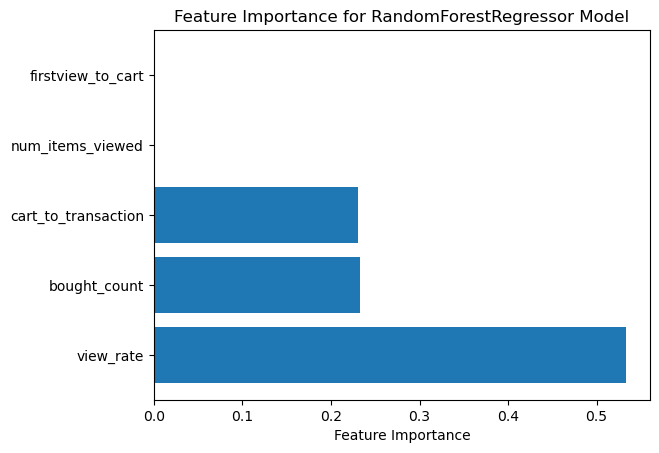

In [238]:
# Sort feature importance values and corresponding feature indices
sorted_idx = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = X.columns[sorted_idx]

# Plot the feature importance values
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance)
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for RandomForestRegressor Model')
plt.show()

### 3.3.3 XGBoostRegressor

In [178]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('xgb', XGBRegressor())])

r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

0.9936030937168236


In [181]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('xgb', XGBRegressor())])

# Perform cross-validation with 'neg_mean_squared_error' as the scoring metric
mse = -1 * cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = np.mean(mse)

print(mean_mse)

0.0010289051005866847


### 3.3.4 XGBRFRegressor

In [185]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('xgb', XGBRFRegressor())])

r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

0.972974771905557


In [186]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('xgb', XGBRFRegressor())])

# Perform cross-validation with 'neg_mean_squared_error' as the scoring metric
mse = -1 * cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse = np.mean(mse)

print(mean_mse)

0.004223457508777248


### 3.3.5 Neural Network

In [165]:
from keras.metrics import MeanAbsoluteError
mae = MeanAbsoluteError()

# Define a function to create the neural network model
def create_nn_model(input_dim):
    model = Sequential()
    # first layer
    model.add(Dense(10, input_dim=input_dim, activation='relu'))  # Update input_dim to match the number of input features
    # output layer
    model.add(Dense(1))  # Output layer with a single node for regression
    # train the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=mae)  # Use Adam optimizer and mean squared error loss
    return model

# Create the pipelines for imputing and scaling
fvc_pipeline = Pipeline([
    ('Impute_fvc', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1000))
])

cta_pipeline = Pipeline([
    ('Impute_cta', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=2000))
])

# Create the preprocessor column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('fvc_pipe', fvc_pipeline, ['firstview_to_cart']),
        ('cta_pipe', cta_pipeline, ['cart_to_transaction']),
    ], remainder='passthrough'
)

# Create the neural network model and wrap it with KerasRegressor
input_dim = 5  # Update input_dim to match the number of input features
nn = KerasRegressor(model=create_nn_model(input_dim), epochs=10, batch_size=32)  # number of epochs and batch size can be adjusted

# Create the final pipeline with the neural network model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('nn', nn)])

# Fit and evaluate the pipeline using cross-validation
r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmpdo_6r5ba\assets


INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmpdo_6r5ba\assets


Epoch 1/10
258/258 [==============================] - 1s 1ms/step - loss: 0.1367 - mean_absolute_error: 0.2603
Epoch 2/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0887 - mean_absolute_error: 0.2051
Epoch 3/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0718 - mean_absolute_error: 0.1835
Epoch 4/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0609 - mean_absolute_error: 0.1654
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0547 - mean_absolute_error: 0.1553
Epoch 6/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0505 - mean_absolute_error: 0.1475
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0473 - mean_absolute_error: 0.1402
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0448 - mean_absolute_error: 0.1337
Epoch 9/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0427 - mean_absolute_error: 0.1278
E

INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmpiu4ldsxj\assets


INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmpiu4ldsxj\assets


Epoch 1/10
258/258 [==============================] - 1s 2ms/step - loss: 0.1509 - mean_absolute_error: 0.2643
Epoch 2/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0964 - mean_absolute_error: 0.2101
Epoch 3/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0823 - mean_absolute_error: 0.1929
Epoch 4/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0727 - mean_absolute_error: 0.1769
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0668 - mean_absolute_error: 0.1688
Epoch 6/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0633 - mean_absolute_error: 0.1616
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0593 - mean_absolute_error: 0.1552
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0558 - mean_absolute_error: 0.1479
Epoch 9/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0531 - mean_absolute_error: 0.1419
E

INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmptzcidhbf\assets


INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmptzcidhbf\assets


Epoch 1/10
258/258 [==============================] - 1s 1ms/step - loss: 0.1501 - mean_absolute_error: 0.2633
Epoch 2/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0962 - mean_absolute_error: 0.2083
Epoch 3/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0795 - mean_absolute_error: 0.1850
Epoch 4/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0684 - mean_absolute_error: 0.1695
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0616 - mean_absolute_error: 0.1592
Epoch 6/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0566 - mean_absolute_error: 0.1518
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0526 - mean_absolute_error: 0.1438
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0495 - mean_absolute_error: 0.1366
Epoch 9/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0472 - mean_absolute_error: 0.1319
E

INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmp02fh_mt5\assets


INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmp02fh_mt5\assets


Epoch 1/10
258/258 [==============================] - 1s 1ms/step - loss: 0.1294 - mean_absolute_error: 0.2595
Epoch 2/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.2040
Epoch 3/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0789 - mean_absolute_error: 0.1877
Epoch 4/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0703 - mean_absolute_error: 0.1746
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0645 - mean_absolute_error: 0.1660
Epoch 6/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0605 - mean_absolute_error: 0.1581
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0571 - mean_absolute_error: 0.1501
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0539 - mean_absolute_error: 0.1441
Epoch 9/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0515 - mean_absolute_error: 0.1385
E

INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmpy2s3cfy9\assets


INFO:tensorflow:Assets written to: C:\Users\Hanme\AppData\Local\Temp\tmpy2s3cfy9\assets


Epoch 1/10
258/258 [==============================] - 1s 1ms/step - loss: 0.1255 - mean_absolute_error: 0.2559
Epoch 2/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0884 - mean_absolute_error: 0.2035
Epoch 3/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0772 - mean_absolute_error: 0.1865
Epoch 4/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0694 - mean_absolute_error: 0.1735
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0636 - mean_absolute_error: 0.1642
Epoch 6/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0590 - mean_absolute_error: 0.1567
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0554 - mean_absolute_error: 0.1494
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0525 - mean_absolute_error: 0.1429
Epoch 9/10
258/258 [==============================] - 0s 2ms/step - loss: 0.0492 - mean_absolute_error: 0.1366
E

In [175]:
pipe.fit(X, y)
history = pipe.named_steps['nn'].model.history

Epoch 1/10
322/322 [==============================] - 1s 2ms/step - loss: 0.0393 - mean_absolute_error: 0.1096
Epoch 2/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0377 - mean_absolute_error: 0.1033
Epoch 3/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0359 - mean_absolute_error: 0.0979
Epoch 4/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0346 - mean_absolute_error: 0.0940
Epoch 5/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0331 - mean_absolute_error: 0.0898
Epoch 6/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0316 - mean_absolute_error: 0.0869
Epoch 7/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0305 - mean_absolute_error: 0.0843
Epoch 8/10
322/322 [==============================] - 1s 2ms/step - loss: 0.0290 - mean_absolute_error: 0.0824
Epoch 9/10
322/322 [==============================] - 0s 1ms/step - loss: 0.0272 - mean_absolute_error: 0.0783
E

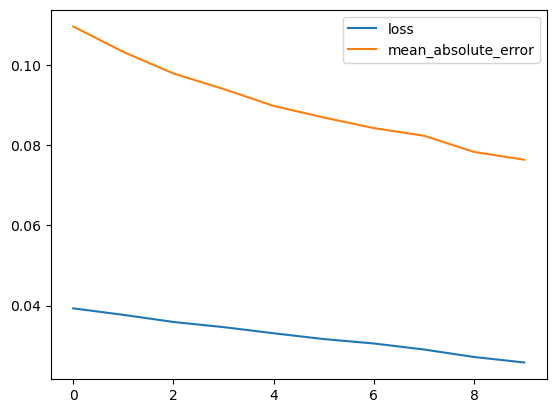

In [176]:
pd.DataFrame(history.history).plot();

- By comparing the r2 score of linear regression, polynomial regression and neural network, it can be found that the scores are 0.36412359612556333, 0.43741591439839744, 0.6050035392340462 respectively. Thus, neural network is selected as the algorithm and used for following grid search and hyperparameter tuning. 

## 3.4 Grid Search and Hyperparameter tuning for Neural Network

- As the other model obtained very good fit, they may not need for hyperparameter tuning. 
- This section aims to try GS for neural network for practice.

In [182]:
# Create the pipelines for imputing and scaling
fvc_pipeline = Pipeline([
    ('Impute_fvc', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1000))
])

cta_pipeline = Pipeline([
    ('Impute_cta', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=2000))
])

# Create the preprocessor column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('fvc_pipe', fvc_pipeline, ['firstview_to_cart']),
        ('cta_pipe', cta_pipeline, ['cart_to_transaction']),
    ], remainder='passthrough'
)

# Define the neural network model directly within the pipeline
nn = KerasRegressor(build_fn=lambda: Sequential([
    # first layer
    Dense(10, input_dim=5, activation='relu'),
    # second layer
    Dense(5, activation='relu'),
    # output layer
    Dense(1,activation='linear')
]), epochs=10, batch_size=32, optimizer='adam', loss='mean_squared_error')  # number of epochs and batch size can be adjusted

# Create the final pipeline with the neural network model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('nn', nn)])

# Fit and evaluate the pipeline using cross-validation
r2 = cross_val_score(pipe, X, y, cv=3, scoring='r2')
mean_r2 = np.mean(r2)

print(mean_r2)

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
215/215 [==============================] - 1s 1ms/step - loss: 0.2315
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0773
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0673
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0626
Epoch 5/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0558
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0495
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 10/10
108/108 [==============================] - 0s 1ms/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.3998
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.2035
Epoch 3/10
215/215 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 4/10
215/215 [==============================] - 0s 2ms/step - loss: 0.1488
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1325
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1183
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1069
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0984
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0923
Epoch 10/10
108/108 [==============================] - 0s 1ms/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1351
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0866
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0798
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0734
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0672
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0612
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0567
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 10/10
108/108 [==============================] - 0s 855us/step
0.642493110185181


In [183]:
# Define the hyperparameter grid
param_grid = {
    'nn__epochs': [10, 20],  # Vary the number of epochs
    'nn__batch_size': [32, 64],  # Vary the batch size
    'nn__optimizer': ['adam', 'sgd'],  # Vary the optimizer
}

# Perform grid search with cross-validation
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', error_score='raise')
grid.fit(X, y)

# Get the best hyperparameters and corresponding mean R2 score
best_params = grid.best_params_
best_mean_r2 = grid.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Mean R2 Score: ", best_mean_r2)

Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.5327
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.2426
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1811
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1538
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1360
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1193
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1018
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0811
Epoch 10/10
108/108 [==============================] - 0s 1ms/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1193
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0961
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0886
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0861
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0823
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0798
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0775
Epoch 9/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0749
Epoch 10/10
108/108 [==============================] - 0s 1ms/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.6654
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.2971
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1619
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1155
Epoch 5/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0965
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0883
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0841
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0808
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0783
Epoch 10/10
108/108 [==============================] - 0s 961us/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1888
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1478
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1408
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1392
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.1036
Epoch 6/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 7/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0849
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0816
Epoch 9/10
215/215 [==============================] - 0s 2ms/step - loss: 0.0800
Epoch 10/10
108/108 [==============================] - 0s 1ms/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1047
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0802
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0725
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0710
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0701
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0691
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0681
Epoch 10/10
108/108 [==============================] - 0s 893us/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1055
Epoch 2/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0837
Epoch 3/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0825
Epoch 4/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0811
Epoch 5/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0797
Epoch 6/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0788
Epoch 7/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0778
Epoch 8/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0770
Epoch 9/10
215/215 [==============================] - 0s 1ms/step - loss: 0.0762
Epoch 10/10
108/108 [==============================] - 0s 964us/step
Epoch 1/20


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1586
Epoch 2/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0937
Epoch 3/20
215/215 [==============================] - 0s 2ms/step - loss: 0.0835
Epoch 4/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0780
Epoch 5/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0749
Epoch 6/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0724
Epoch 7/20
215/215 [==============================] - 0s 2ms/step - loss: 0.0695
Epoch 8/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 9/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 10/20
215/215 [==============================] - 0s 2ms/step - loss: 0.0618
Epoch 11/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 12/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0545
Epoch 13/20
215/215 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.2380
Epoch 2/20
215/215 [==============================] - 0s 1ms/step - loss: 0.1287
Epoch 3/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0958
Epoch 4/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0853
Epoch 5/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0775
Epoch 6/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 7/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 8/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 9/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0493
Epoch 10/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0439
Epoch 11/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0393
Epoch 12/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0353
Epoch 13/20
215/215 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1520
Epoch 2/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0860
Epoch 3/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0782
Epoch 4/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0714
Epoch 5/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0656
Epoch 6/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0610
Epoch 7/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0572
Epoch 8/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0537
Epoch 9/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 10/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 11/20
215/215 [==============================] - 0s 2ms/step - loss: 0.0446
Epoch 12/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0424
Epoch 13/20
215/215 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.2098
Epoch 2/20
215/215 [==============================] - 0s 1ms/step - loss: 0.1264
Epoch 3/20
215/215 [==============================] - 0s 1ms/step - loss: 0.1175
Epoch 4/20
215/215 [==============================] - 0s 1ms/step - loss: 0.1010
Epoch 5/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0913
Epoch 6/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0860
Epoch 7/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0827
Epoch 8/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0805
Epoch 9/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0787
Epoch 10/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0776
Epoch 11/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0767
Epoch 12/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0758
Epoch 13/20
215/215 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1830
Epoch 2/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0993
Epoch 3/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0938
Epoch 4/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0911
Epoch 5/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0892
Epoch 6/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0874
Epoch 7/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0858
Epoch 8/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0843
Epoch 9/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0828
Epoch 10/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0813
Epoch 11/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 12/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0791
Epoch 13/20
215/215 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


215/215 [==============================] - 1s 1ms/step - loss: 0.1539
Epoch 2/20
215/215 [==============================] - 0s 1ms/step - loss: 0.1023
Epoch 3/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0936
Epoch 4/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0893
Epoch 5/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0870
Epoch 6/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0854
Epoch 7/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0843
Epoch 8/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0833
Epoch 9/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0825
Epoch 10/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0817
Epoch 11/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0811
Epoch 12/20
215/215 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 13/20
215/215 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 1ms/step - loss: 0.1236
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0890
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0819
Epoch 4/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0769
Epoch 5/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0729
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0682
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0634
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0579
Epoch 9/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 10/10
54/54 [==============================] - 0s 1ms/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 1ms/step - loss: 0.2095
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1085
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0935
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0874
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0831
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0795
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0764
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0731
Epoch 9/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0701
Epoch 10/10
54/54 [==============================] - 0s 907us/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 1ms/step - loss: 0.1804
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1123
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0933
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0839
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0779
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0760
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 9/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 10/10
54/54 [==============================] - 0s 898us/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 0s 1ms/step - loss: 0.2022
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1170
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1079
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1055
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1011
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0983
Epoch 7/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0953
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 9/10
108/108 [==============================] - 0s 952us/step - loss: 0.0889
Epoch 10/10
54/54 [==============================] - 0s 871us/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 0s 1ms/step - loss: 0.1434
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1084
Epoch 3/10
108/108 [==============================] - 0s 1ms/step - loss: 0.1026
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0994
Epoch 5/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0970
Epoch 6/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0951
Epoch 7/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0934
Epoch 8/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 9/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0910
Epoch 10/10
54/54 [==============================] - 0s 840us/step
Epoch 1/10


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 1ms/step - loss: 0.1247
Epoch 2/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0982
Epoch 3/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 4/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 5/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0916
Epoch 6/10
108/108 [==============================] - 0s 1ms/step - loss: 0.0906
Epoch 7/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0895
Epoch 8/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0888
Epoch 9/10
108/108 [==============================] - 0s 2ms/step - loss: 0.0880
Epoch 10/10
54/54 [==============================] - 0s 1ms/step
Epoch 1/20


C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 2ms/step - loss: 0.2840
Epoch 2/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1605
Epoch 3/20
108/108 [==============================] - 0s 2ms/step - loss: 0.1091
Epoch 4/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0879
Epoch 5/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0776
Epoch 6/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0686
Epoch 7/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 8/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0597
Epoch 9/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 10/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0534
Epoch 11/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0513
Epoch 12/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 13/20
108/108 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 2ms/step - loss: 0.2031
Epoch 2/20
108/108 [==============================] - 0s 2ms/step - loss: 0.1072
Epoch 3/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0938
Epoch 4/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0900
Epoch 5/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 6/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 7/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0826
Epoch 8/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0806
Epoch 9/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0785
Epoch 10/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0755
Epoch 11/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0720
Epoch 12/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0695
Epoch 13/20
108/108 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 1ms/step - loss: 0.3731
Epoch 2/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1103
Epoch 3/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0900
Epoch 4/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0837
Epoch 5/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0783
Epoch 6/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0733
Epoch 7/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0692
Epoch 8/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0664
Epoch 9/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 10/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0611
Epoch 11/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 12/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0555
Epoch 13/20
108/108 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 0s 1ms/step - loss: 0.1366
Epoch 2/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0910
Epoch 3/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0880
Epoch 4/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0859
Epoch 5/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 6/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0832
Epoch 7/20
108/108 [==============================] - 0s 1ms/step - loss: 0.0823
Epoch 8/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0815
Epoch 9/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0807
Epoch 10/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0802
Epoch 11/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0797
Epoch 12/20
108/108 [==============================] - 0s 2ms/step - loss: 0.0793
Epoch 13/20
108/108 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 2ms/step - loss: 0.2394
Epoch 2/20
108/108 [==============================] - 0s 2ms/step - loss: 0.1576
Epoch 3/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1402
Epoch 4/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1351
Epoch 5/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1331
Epoch 6/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1321
Epoch 7/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1312
Epoch 8/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1305
Epoch 9/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1298
Epoch 10/20
108/108 [==============================] - 0s 2ms/step - loss: 0.1291
Epoch 11/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1283
Epoch 12/20
108/108 [==============================] - 0s 2ms/step - loss: 0.1275
Epoch 13/20
108/108 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


108/108 [==============================] - 1s 1ms/step - loss: 0.2107
Epoch 2/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1583
Epoch 3/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1537
Epoch 4/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1514
Epoch 5/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1497
Epoch 6/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1471
Epoch 7/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1435
Epoch 8/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1373
Epoch 9/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1280
Epoch 10/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1175
Epoch 11/20
108/108 [==============================] - 0s 2ms/step - loss: 0.1082
Epoch 12/20
108/108 [==============================] - 0s 1ms/step - loss: 0.1021
Epoch 13/20
108/108 [===============

C:\Users\Hanme\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


322/322 [==============================] - 1s 1ms/step - loss: 0.1416
Epoch 2/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0866
Epoch 3/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0732
Epoch 4/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0635
Epoch 5/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 6/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 7/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 8/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0396
Epoch 9/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 10/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0322
Epoch 11/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 12/20
322/322 [==============================] - 0s 1ms/step - loss: 0.0265
Epoch 13/20
322/322 [===============

## 3.5 Stacking

- practice purpose, the score is not improved as the original score from each model is not bad.

In [193]:
# stacking
estimators = [
    ('rf', RandomForestRegressor()),
    ('xgb', XGBRegressor()),
    ('lr', LinearRegression())
]

clf = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

In [194]:
steps = [('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor())]

stacking_pipeline = Pipeline(steps=steps)

In [195]:
scores = cross_val_score(stacking_pipeline, X, y, cv=5, scoring='r2')

mean_r2 = np.mean(scores)

print(mean_r2)

0.9906049860878501


## 3.6 Surrogate model

- use randomforest to check feature importance
- use linear regression to check coefficients

### RandomForest -- Feature Importance

In [265]:
# Fit the black box model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('MLP', MLPRegressor())])

pipe.fit(X_train, y_train)

# Extract features and labels for the surrogate model
X_train_surrogate = pipe.named_steps['preprocessor'].transform(X_train)
y_train_surrogate = y_train

# Train the surrogate model
surrogate_model = DecisionTreeRegressor()
surrogate_model.fit(X_train_surrogate, y_train_surrogate)

# Evaluate the surrogate model
X_test_surrogate = pipe.named_steps['preprocessor'].transform(X_test)
y_pred_surrogate = surrogate_model.predict(X_test_surrogate)
r2_surrogate = r2_score(y_test, y_pred_surrogate)
print('R-squared of surrogate model:', r2_surrogate)

R-squared of surrogate model: 0.977032035353206


In [266]:
feature_names = X.columns.to_list()

In [267]:
# Access the feature importances of the surrogate model
importances = surrogate_model.feature_importances_

# Interpret the feature importances
for i, feature_name in enumerate(feature_names):
    print(f'Feature importance for {feature_name}: {importances[i]}')

Feature importance for num_items_viewed: 0.003359614210517741
Feature importance for firstview_to_cart: 0.002483795121983406
Feature importance for cart_to_transaction: 0.22899300250472182
Feature importance for bought_count: 0.21900081657200782
Feature importance for view_rate: 0.5461627715907691


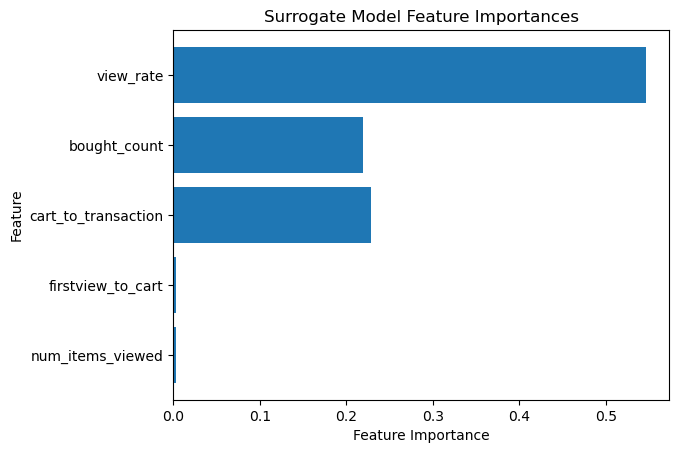

In [268]:
num_features = len(feature_names)

# Plot the feature importances as a horizontal bar chart
plt.barh(range(num_features), importances)
plt.yticks(range(num_features), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Surrogate Model Feature Importances')
plt.show()

### LinearRegression --- Model Coefficients

In [242]:
# Fit the black box model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('MLP', MLPRegressor())])

pipe.fit(X_train, y_train)

# Extract features and labels for the surrogate model
X_train_surrogate = pipe.named_steps['preprocessor'].transform(X_train)
y_train_surrogate = y_train

# Train the surrogate model
surrogate_model = LinearRegression()
surrogate_model.fit(X_train_surrogate, y_train_surrogate)

# Evaluate the surrogate model
X_test_surrogate = pipe.named_steps['preprocessor'].transform(X_test)
y_pred_surrogate = surrogate_model.predict(X_test_surrogate)
r2_surrogate = r2_score(y_test, y_pred_surrogate)
print('R-squared of surrogate model:', r2_surrogate)

R-squared of surrogate model: 0.341366587157535


In [243]:
# Access the coefficients of the surrogate model
coefficients = surrogate_model.coef_

# Interpret the coefficients
for i, feature_name in enumerate(feature_names):
    print(f'Coefficient for {feature_name}: {coefficients[i]}')

Coefficient for num_items_viewed: 8.694203568922183e-06
Coefficient for firstview_to_cart: -8.984617764023474e-05
Coefficient for cart_to_transaction: -0.002233182827355004
Coefficient for bought_count: 0.010642655076495689
Coefficient for view_rate: 0.8081414185413979


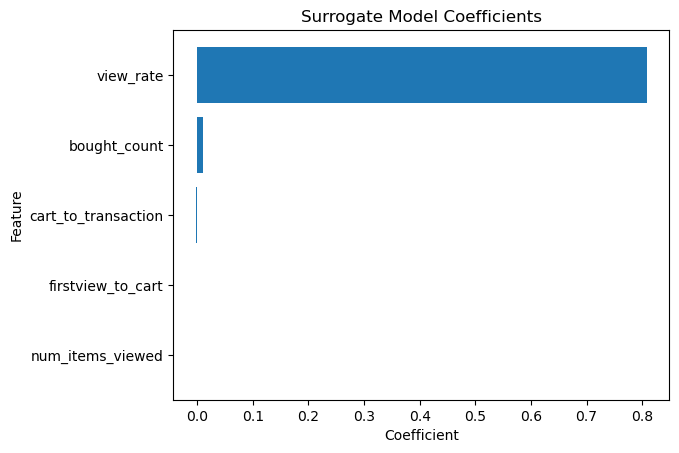

In [244]:
num_features = len(feature_names)

# Plot the coefficients as a horizontal bar chart
plt.barh(range(num_features), coefficients)
plt.yticks(range(num_features), feature_names)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Surrogate Model Coefficients')
plt.show()

## 3.7 Permutation Importance

In [262]:
import eli5
from eli5.sklearn import PermutationImportance

# Fit the black box model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('scaler', StandardScaler()),
                       ('MLP', MLPRegressor())])

pipe.fit(X_train, y_train)

# Extract features and labels for the surrogate model
X_train_perm = pipe.named_steps['preprocessor'].fit_transform(X_train)
X_train_perm = StandardScaler().fit_transform(X_train_perm)
y_train_perm = y_train

perm = PermutationImportance(pipe.named_steps['MLP'], random_state=1)


perm.fit(X_train_perm, y_train_perm)

eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
27.1245 ± 0.2626,cart_to_transaction
25.8921 ± 2.2240,bought_count
0.8136 ± 0.0388,view_rate
0.0280 ± 0.0036,firstview_to_cart
0.0061 ± 0.0011,num_items_viewed


### Questions:

- Why the importance is various from different strategy? Which one would be more reliable?
    - Surrangate' feature importance rely on the model, in this case, DT. It shows the importance to the model, not real feature importance.
    - Permutation is more reliable for real feature importance.

### Business Insights:
- The feature importance from Permutation shows that the cart_to_transaction and bought_count are more important to predict a customer who has high possibility buying a product online, which is reasonable. 
- In other words, the behavior of firstview_to_cart and num_items_viewed is implict while cart_to_transaction and bought_count are explict features.
- For business purpose, maintain their regular customer or return customer would be important to keep even increase the order value. 

# 4. Recommendation System

- Logics for item-item based recommendation system:
    - Collaborative filtering
        - find the custommer who made purchase
        - find their purchased items
        - define a function to return a list of same item in purchase
    - Content based recommender
        - add similar products that in the same category or same parentid with top purchase frequency to the list

In [84]:
# for custommer who have purchase experience
# first - create a list of visitors who made a purchase
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()

# create a list of purchased items, the values refer to the item_id of every customer
purchased_items = []

for customer in customer_purchased:
    
    purchased_items.append(list(events.loc[(events.visitorid == customer) & (events.transactionid.notnull())].itemid.values))

In [85]:
# purchased_items for each unique customer, minimal len of purchased[i] = 1
len(purchased_items)

11719

In [86]:
# purchased_items for each customer, first column is the visitor_id, the rest are itemid that this customer purchased.
pd.DataFrame(purchased_items)

,0,1,2,3,4,5,6,7,8,9,...,549,550,551,552,553,554,555,556,557,558
0,356475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15335,380775.0,237753.0,317178.0,12836.0,400969.0,105792.0,25353.0,200793.0,80582.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,81345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,150318,49521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,310791,299044.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11714,20968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11715,418693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11716,430050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11717,31640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
# Write a function that would show items that were bought by the same customer
def recommend_items(item_id, purchased_items):
    # put the arrays containing that item id in a new list
    recommendation_list =[]
    for x in purchased_items:
        if item_id in x:
            recommendation_list += x
            # print (x)
            
    #Then merge recommender list and remove the item id and duplicates
    recommendation_list = list(set(recommendation_list) - set([item_id]))
    # print (set([item_id]))
    return recommendation_list

In [270]:
recommend_items(150318, purchased_items)

[49521]

### Comments: 
- This is a very crude way of recommending other items to the visitor
- inaccurate: based on purchase history, some items return none recommendation; some item only returns the purchase history of that specific customer
- The following work is to add more recommendation based on item's category information

In [89]:
data = pd.read_csv('data.csv')
data.head()

,timestamp,visitorid,event,itemid,transactionid,categoryid,parentid
0,2015-06-01 22:02:12,257597,view,355908,NaN,1173,805.0
1,2015-06-01 13:42:45,981382,view,355908,NaN,1173,805.0
2,2015-06-08 21:07:35,979686,view,355908,NaN,1173,805.0
3,2015-06-15 08:31:50,479732,view,355908,NaN,1173,805.0
4,2015-06-14 16:51:34,397425,view,355908,NaN,1173,805.0


In [90]:
# Drop unnecessary columns
data.drop(['timestamp', 'transactionid'], axis=1, inplace=True)

In [91]:
data['event'].unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [92]:
# Drop duplicates
data.drop_duplicates(inplace=True)

In [93]:
data = data[data['event'] == 'transaction']

In [94]:
data.drop(['event'], axis=1, inplace=True)

In [95]:
freq_table = pd.DataFrame(data.groupby(['parentid', 'categoryid'])['itemid'].value_counts())
freq_table = freq_table.rename(columns={'itemid': 'frequency'})
freq_table.head()

frequency
parentid categoryid itemid           
9.0      142        78474           1
                    97348           1
                    268417          1
                    328005          1
         570        173589          4

In [96]:
# size(): count of occurrences for each combination
freq_table = data.groupby(['parentid', 'categoryid', 'itemid']).size().reset_index(name='frequency')
freq_table.head(10)

,parentid,categoryid,itemid,frequency
0,9.0,142,78474,1
1,9.0,142,97348,1
2,9.0,142,268417,1
3,9.0,142,328005,1
4,9.0,570,173589,4
5,9.0,1189,8847,2
6,9.0,1189,18454,1
7,9.0,1189,25170,1
8,9.0,1189,40542,1
9,9.0,1189,81155,2


In [271]:
# Step 1: Filter the data DataFrame to get the row corresponding to the given itemid
item_id = 150318
selected_row = freq_table[freq_table['itemid'] == item_id]

# Step 2: Extract the parentid and categoryid values from the selected row
selected_parentid = selected_row['parentid'].iloc[0]
# print(selected_parentid)
selected_categoryid = selected_row['categoryid'].iloc[0]
# print(selected_categoryid)

# Step 3: Filter the data DataFrame to get rows with the same parentid and categoryid
same_parentid_group = freq_table[freq_table['parentid'] == selected_parentid]
same_categoryid_group = freq_table[freq_table['categoryid'] == selected_categoryid]

# Step 4: Filter the rows to exclude the selected itemid
same_parentid_group = same_parentid_group[same_parentid_group['itemid'] != item_id]
same_categoryid_group = same_categoryid_group[same_categoryid_group['itemid'] != item_id]

list_1 = same_categoryid_group['itemid'].tolist()
print(list_1)

# Step 5: Sort the filtered DataFrame by the count of itemid occurrences in descending order
same_parentid_group = same_parentid_group.sort_values('frequency', ascending=False)
list_2 = same_parentid_group['itemid'].head().tolist()
print(list_2)

# Step 6: combine two list into one
top_5_itemids = list_1 + list_2

# Step 7: Print the list of top 10 itemids
print("The similar items:")
print(top_5_itemids)

[19972, 27216, 34250, 312414, 358598]
[111530, 459475, 403969, 238766, 230911]
The similar items:
[19972, 27216, 34250, 312414, 358598, 111530, 459475, 403969, 238766, 230911]


## Final RS model

In [256]:
# Write a function that would show items that were bought by the same customer
def recommend_items(item_id, purchased_items):
    recommendation_list =[]
    for x in purchased_items:
        if item_id in x:
            recommendation_list += x
    
    # Step 1: Filter the data DataFrame to get the row corresponding to the given itemid
    selected_row = freq_table[freq_table['itemid'] == item_id]

    # Step 2: Extract the parentid and categoryid values from the selected row
    selected_parentid = selected_row['parentid'].iloc[0]
    # print(selected_parentid)
    selected_categoryid = selected_row['categoryid'].iloc[0]
    # print(selected_categoryid)

    # Step 3: Filter the data DataFrame to get rows with the same parentid and categoryid
    same_parentid_group = freq_table[freq_table['parentid'] == selected_parentid]
    same_categoryid_group = freq_table[freq_table['categoryid'] == selected_categoryid]

    # Step 4: Filter the rows to exclude the selected itemid
    same_parentid_group = same_parentid_group[same_parentid_group['itemid'] != item_id]
    same_categoryid_group = same_categoryid_group[same_categoryid_group['itemid'] != item_id]

    list_1 = same_categoryid_group['itemid'].tolist()
    # print(list_1)

    # Step 5: Sort the filtered DataFrame by the count of itemid occurrences in descending order
    same_parentid_group = same_parentid_group.sort_values('frequency', ascending=False)
    list_2 = same_parentid_group['itemid'].head().tolist()
    # print(list_2)

    # Step 6: Combine two list into one
    top_5_itemids = list_1 + list_2

    # Step 7: Print the list of top 10 itemids
    # print("The similar items:")
    # print(top_5_itemids)
            
    #Then merge recommender list and remove the item id
    recommendation_list = list(set(recommendation_list) - set([item_id])) + top_5_itemids
    recommendation_list = list(set(recommendation_list))
    
    return recommendation_list

In [99]:
recommend_items(150318, purchased_items)

[403969,
 19972,
 358598,
 34250,
 111530,
 238766,
 27216,
 49521,
 459475,
 312414,
 230911]

### Next:

- Any other method for simpleImputer instead of fill the constant value?

- How to evaluate the recommendation model without similarity scores?